## Assignment 1b: Time Series Forecasting

### \<Christian Ataiza> \<1882443>

#### Follow detail instructions in the assignment specification and use these heading for implementation and discussion

### 1. Read the dataset

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller as s_ADF
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from pmdarima import auto_arima

import tensorflow as tf

In [2]:
# set seed for reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# loading in the dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv(r'energydata_complete.csv') 
df['date'] = pd.to_datetime(df.date, format = "%d/%m/%Y %H:%M")

In [4]:
# preview the first 5 rows of the dataset
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
# view the feature names
columns = df.columns
columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [6]:
# view the size of the dataframe
df.shape

(19735, 29)

#### Check for missing Data

In [7]:
df.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

It can be observed that there is no need to impute for missing data.

### 2. Analyse and visualise the data

#### 2.1. Data Dictionary

Shows the interpretation of meaning of the feature names to their respective meanings.

| Data variables                        | Feature Name in Table | Units           |
|----------------------------------------|-----------------------|-----------------|
| Datetime stamp | dd-mm-yy hh:ss | date                   |
| Appliances energy consumption          | appliances            | Wh              |
| Light energy consumption               | light                 | Wh              |
| T1, Temperature in kitchen area        | T1                    | °C              |
| RH1, Humidity in kitchen area          | RH_1                  | %               |
| T2, Temperature in living room area    | T2                    | °C              |
| RH2, Humidity in living room area      | RH_2                  | %               |
| T3, Temperature in laundry room area   | T3                    | °C              |
| RH3, Humidity in laundry room area     | RH_3                  | %               |
| T4, Temperature in office room         | T4                    | °C              |
| RH4, Humidity in office room           | RH_4                  | %               |
| T5, Temperature in bathroom            | T5                    | °C              |
| RH5, Humidity in bathroom              | RH_5                  | %               |
| T6, Temperature outside the building (north side) | T6      | °C              |
| RH6, Humidity outside the building (north side)   | RH_6    | %               |
| T7, Temperature in ironing room        | T7                    | °C              |
| RH7, Humidity in ironing room          | RH_7                  | %               |
| T8, Temperature in teenager room 2     | T8                    | °C              |
| RH8, Humidity in teenager room 2       | RH_8                  | %               |
| T9, Temperature in parents room        | T9                    | °C              |
| RH9, Humidity in parents room          | RH_9                  | %               |
| To, Temperature outside (from Chièvres weather station) | T_out | °C              |
| Pressure (from Chièvres weather station) | Press_mm_hg         | mm Hg           |
| RHo, Humidity outside (from Chièvres weather station) | RH_out   | %           |
| Windspeed (from Chièvres weather station) | Windspeed           | m/s             |
| Visibility (from Chièvres weather station) | Visbility           | km              |
| Tdewpoint (from Chièvres weather station) | Tdewpoint           | °C              |
| Random Variable 1 (RV 1)               | rv1                   | Non-dimensional |
| Random Variable 2 (RV 2)               | rv2                   | Non-dimensional |


In the paper (Candenado, et al., 2017)[1] of the reading, `rv1` and `rv2` are variables made to introduce random noise for the purposes of Feature Selection using the Bortua packer for Feature Selection. These variables will be dropped.

In [8]:
df.drop(['rv1','rv2'], axis = 1, inplace = True)

#### 2.2 Identify the data types of each variable

In [9]:
df.dtypes

date           datetime64[ns]
Appliances              int64
lights                  int64
T1                    float64
RH_1                  float64
T2                    float64
RH_2                  float64
T3                    float64
RH_3                  float64
T4                    float64
RH_4                  float64
T5                    float64
RH_5                  float64
T6                    float64
RH_6                  float64
T7                    float64
RH_7                  float64
T8                    float64
RH_8                  float64
T9                    float64
RH_9                  float64
T_out                 float64
Press_mm_hg           float64
RH_out                float64
Windspeed             float64
Visibility            float64
Tdewpoint             float64
dtype: object

It can be observed that in the dictionary and in the data types that the values of each variable is continuous. 

#### 2.3. Feature Engineering

The paper also derived features from the dataset the proved to be insightful at predicting the features.


These were:
| Data variables                        | Feature Name in Table | Units           |
|----------------------------------------|-----------------------|-----------------|
| Number of seconds after midnight for each day | nsm | seconds                   |
| Week status         | W_status            | Weekend, Weekday              |
| Day of the week               | Dy_week_               | Mon, Tue, Wed, Thurs, Fri, Sat, Sun              |


However, the last two features derived were categorical which entails that [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)[2] is needed to be used to make the data suitable for a machine learning model.  

In [10]:
# Calculating for the derived fields

# NSM
df['nsm'] = ((df['date'] - df['date'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)

# Day of the week
day = {0: 'mon', 1: 'tues', 2: 'wed', 3: 'thurs', 4: 'fri', 5: 'sat', 6: 'sun'}
df['Dy_week'] = df['date'].apply(lambda x : day[x.weekday()])

# Week status
df['W_status'] = df['Dy_week'].apply(lambda x: 'weekday' if x not in ('sat', 'sun') else 'weekend')

# set date as index 
df.set_index("date",inplace=True)

In [11]:
# check sample to validate if FE was done correctly
df.sample(5)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,nsm,Dy_week,W_status
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-03-14 01:40:00,40,0,20.890000,35.400000,17.760000,39.163333,20.290000,36.900000,19.760000,34.200000,18.600000,51.290000,1.198571,63.817857,21.60,33.663333,23.068750,39.747500,19.29,39.03,1.770,768.90,88.333333,2.333333,63.000000,0.00,6000,mon,weekday
2016-01-30 20:00:00,90,10,21.890000,53.100000,21.290000,45.360000,21.633333,49.226667,20.533333,40.966667,17.677778,58.204444,2.530000,97.090000,16.89,39.345000,20.616667,47.563333,16.29,44.20,2.700,754.60,90.000000,3.000000,27.000000,1.20,72000,sat,weekend
2016-03-15 03:00:00,50,0,21.390000,35.500000,17.633333,40.530000,21.666667,35.200000,20.290000,33.760000,19.600000,40.290000,-0.266667,50.930000,20.79,27.290000,22.100000,39.626667,19.39,38.29,0.200,766.20,83.000000,2.000000,65.000000,-2.40,10800,tues,weekday
2016-04-20 10:10:00,50,0,21.390000,41.033333,23.890000,34.840000,22.033333,36.933333,22.390000,35.236000,19.633333,43.266667,11.160000,10.296667,20.05,30.390000,21.200000,38.090000,20.29,38.56,8.850,767.80,70.833333,5.166667,40.000000,3.72,36600,wed,weekday
2016-03-13 08:10:00,70,0,19.963333,35.126667,16.463333,40.126667,20.000000,36.400000,19.260000,34.966667,17.890000,49.000000,-0.733333,71.230000,20.39,34.060000,22.100000,39.590000,19.00,40.70,-0.467,769.65,93.333333,4.000000,48.833333,-1.45,29400,sun,weekend


#### 2.4. Visualization of the Dataset

##### 2.4.1. Visualizing Target

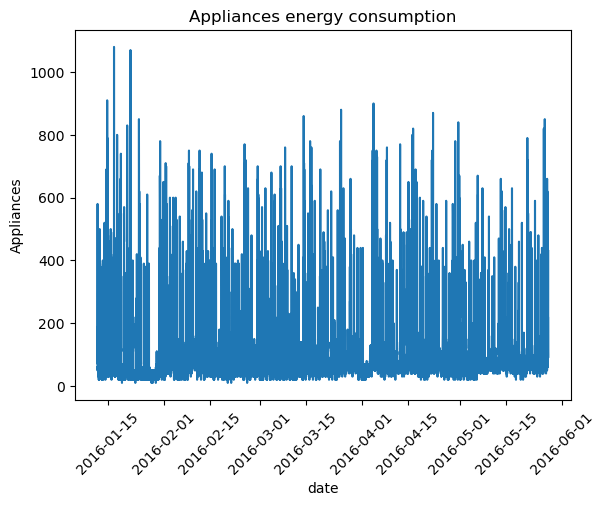

<Figure size 640x480 with 0 Axes>

In [12]:
# Visualizing target with respect to date
sns.lineplot(x=df.index, y="Appliances", data=df)
plt.xticks(rotation = 45)
plt.title("Appliances energy consumption")
plt.show()
plt.clf()

Given that the target variable, appliance, [reading data is continuous](https://www.sciencedirect.com/science/article/pii/S266654682030009), a kdeplot was used to visualize the distribution.

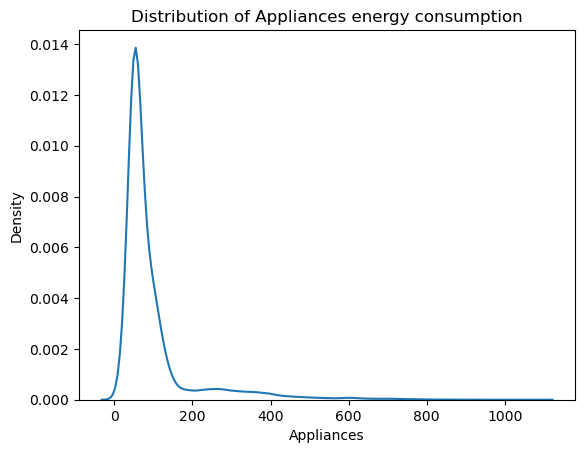

<Figure size 640x480 with 0 Axes>

In [13]:
sns.kdeplot(data=df, x="Appliances")
plt.title("Distribution of Appliances energy consumption")
plt.show()
plt.clf()

The most common readings are within the ranges of 0 to ~ 200 Wh.

##### 2.4.2. Visualizing the non-target Features

In [14]:
# Keep track of the numeric features to be used for the distributions later
num_feat = [feat for feat in df.columns if feat not in ('Dy_week', 'W_status')]

**2.4.2.1. Numerical Features**

In [15]:
# Show five number summary using df.describe()
df[num_feat].describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,nsm
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.412580,755.522602,79.750418,4.039752,38.330834,3.760995,42907.129465
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.318464,7.399441,14.901088,2.451221,11.794719,4.195248,24940.020831
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.000000
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.670000,750.933333,70.333333,2.000000,29.000000,0.900000,21600.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.920000,756.100000,83.666667,3.666667,40.000000,3.430000,43200.000000
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.400000,760.933333,91.666667,5.500000,40.000000,6.570000,64200.000000
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,85800.000000


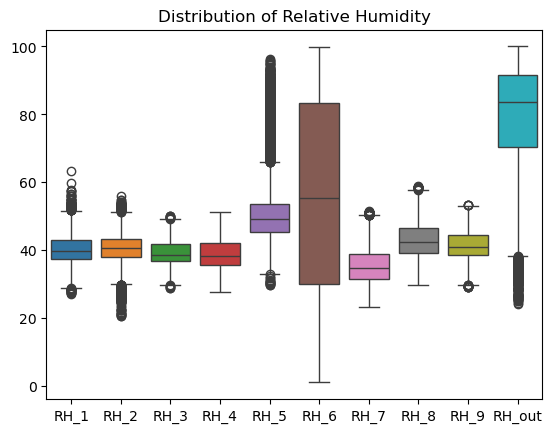

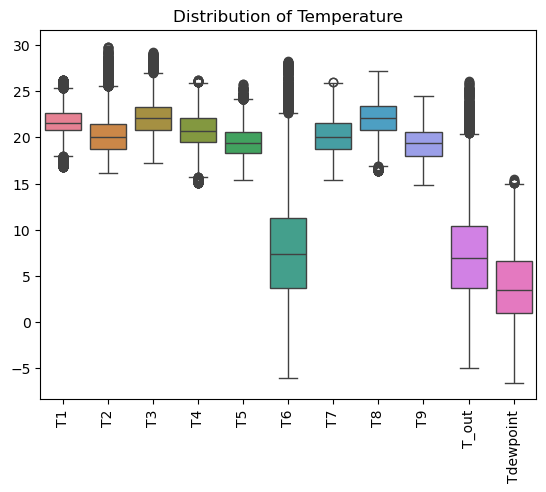

In [16]:
# Visualize Distributions with box-plots
sns.boxplot(data = df[[feat for feat in num_feat if feat[:2] == 'RH']])
plt.title("Distribution of Relative Humidity")
plt.show()

sns.boxplot(data = df[[feat for feat in num_feat if feat[:1] == 'T']])
plt.title("Distribution of Temperature")
plt.xticks(rotation = 90)
plt.show()


It can be observed that the distribution of the outdoor temperatures and humidity is wider than that of the temperature and humidity indoors. Moreover, The recorded temperature inside the house is higher that the outside while also having a lower humidity on average. However, it must be noted that RH_5 (humidity in the bathroom) have more outliers due to the nature of its use with respect to the humidity with the rest of the house. This may be important for our predictors later.

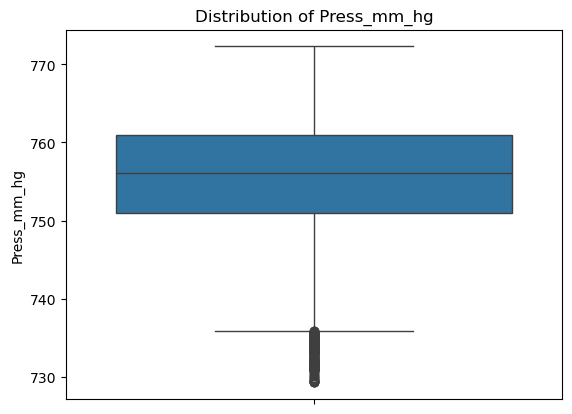

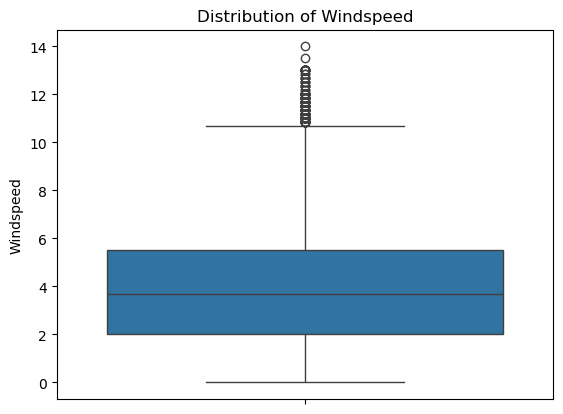

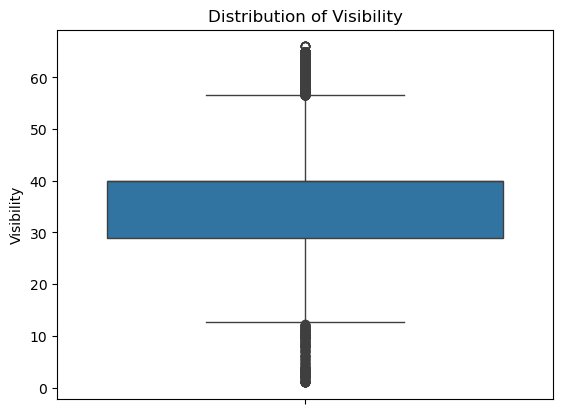

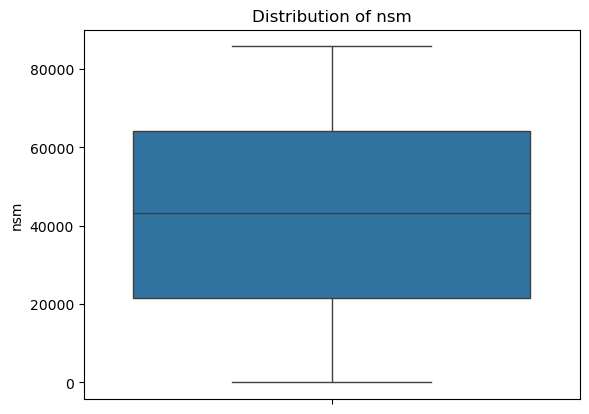

In [17]:
# Visualizing the rest of the numerical features
for feat in [feat for feat in num_feat if not(feat[:2] == 'RH' or feat[:1] == 'T')][2:]:
    sns.boxplot(data = df[feat])
    plt.title(f"Distribution of {feat}")
    plt.show()

Some important observations:
- nsm looks to be (approximately) distributed uniformly meaning enough representatives of times of days are recorded
- lights appear to be discrete which implies that the light usage are configured to certain specifications

In [18]:
# To confirm the nsm hypothesis above
df['nsm'].value_counts()

nsm
61200    138
62400    138
63000    138
63600    138
64200    138
        ... 
1800     137
1200     137
600      137
0        137
60600    137
Name: count, Length: 144, dtype: int64

**2.4.2.2. Categorical Features**

In [19]:
df[['Dy_week', 'W_status']].describe()

,Dy_week,W_status
count,19735,19735
unique,7,2
top,tues,weekday
freq,2880,14263


##### 2.4.3. Correlation Matrix

In [20]:
# Transform categorical data with OHE to make derive the correlation coefficient in place
def OHEdf(df, column_name):
    """Given a data frame and a column,
    append the dummy columns to df in place.
    Get rid of original column"""
    to_add = pd.get_dummies(df[column_name],prefix = column_name)
    df.drop(column_name, axis = 1, inplace = True)
    df = pd.concat([df,to_add], axis = 1)
    return df

In [21]:
df = OHEdf(df, 'W_status')
df = OHEdf(df, 'Dy_week')

In [22]:
# Checking to see if the categorical data was successfully transformed
df.head()
feat_names = df.columns
feat_names

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'nsm', 'W_status_weekday', 'W_status_weekend',
       'Dy_week_fri', 'Dy_week_mon', 'Dy_week_sat', 'Dy_week_sun',
       'Dy_week_thurs', 'Dy_week_tues', 'Dy_week_wed'],
      dtype='object')

In [23]:
# View correlation of features with respect to target
df.corr()['Appliances'].sort_values(ascending=False)[1:]

nsm                 0.217152
lights              0.197278
T2                  0.120073
T6                  0.117638
T_out               0.099155
Windspeed           0.087122
RH_1                0.086031
T3                  0.085060
T1                  0.055447
Dy_week_mon         0.054307
T4                  0.040281
T8                  0.039572
RH_3                0.036292
Dy_week_sat         0.033463
Dy_week_fri         0.027731
T7                  0.025801
T5                  0.019760
W_status_weekend    0.017437
RH_4                0.016965
Tdewpoint           0.015357
T9                  0.010010
RH_5                0.006955
Visibility          0.000230
Dy_week_sun        -0.010875
W_status_weekday   -0.017437
Dy_week_thurs      -0.029276
Dy_week_wed        -0.031306
Press_mm_hg        -0.034885
Dy_week_tues       -0.042617
RH_9               -0.051462
RH_7               -0.055642
RH_2               -0.060465
RH_6               -0.083178
RH_8               -0.094039
RH_out        

/var/folders/gg/27ydp9614p9cpq8pg5r7rklc0000gn/T/ipykernel_3100/699871043.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(values, orient='h', palette = colors)


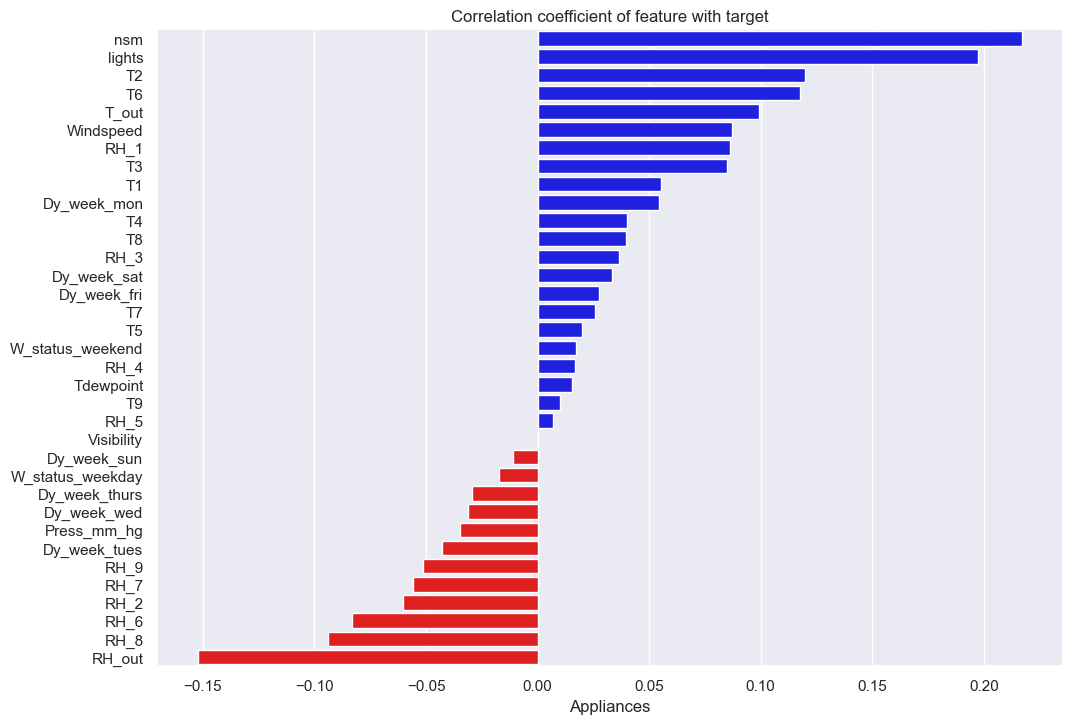

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
values = df.corr()['Appliances'].sort_values(ascending=False)[1:] 
colors = ['red' if x < 0 else 'blue' for x in values]
sns.barplot(values, orient='h', palette = colors)
plt.title('Correlation coefficient of feature with target')
plt.show()

It can be seen above that features `nsm`, `lights`,` T2`, `T6`, and `T_out` exhibit a somewhat positive correlation with the target variable Appliances, while `RH_out`, `RH_8` ,`RH_6` somewhat negative correlation with target variable Appliances

<Axes: >

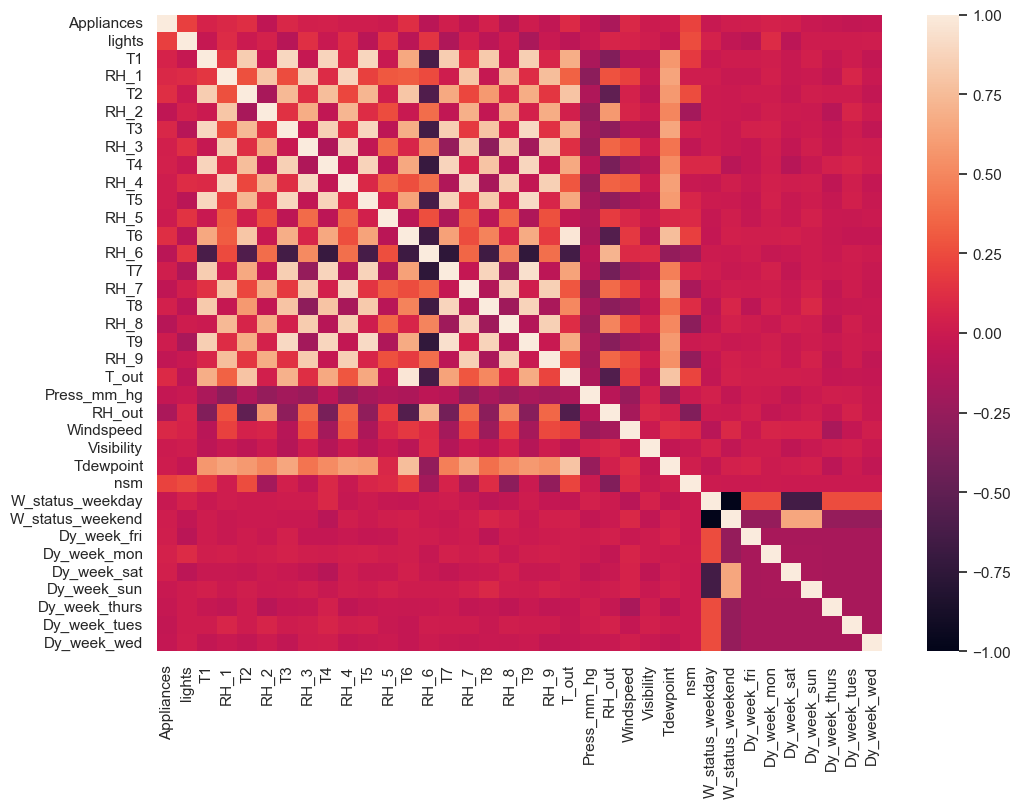

In [25]:
sns.heatmap(df.corr())

### 3. Pre-process the data

#### 3.1. Normalization

Since the objective of this assignment is to predict using Time-series Forecasting using ARIMA and the sequential RNN Model LSTM, [it would be beneficial to normalize the data to let the features to be zero-centered](https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/). Like the last assignment, for the purposes of this paper, to avoid data leakage, the data is first split and then normalized. Unlike the reference paper, we will also normalize the target feature - to aid with the speed of training. Remember that ARIMA handles differencing and that will be explained when we do Time-series analysis as part of our Data-preparation. 

This paper is doing a 70-30 train-test split, and since this dataset is timeseries, we cannot use random train-test split.

In [26]:
# Split at the 70% observation. 
split_at = int(df.shape[0] * 0.7)
train = df.iloc[:split_at,:]
test = df.iloc[split_at:,:]

In [27]:
# last observation of train
max(train.index)

Timestamp('2016-04-16 15:10:00')

In [28]:
# first observation of test
min(test.index)

Timestamp('2016-04-16 15:20:00')

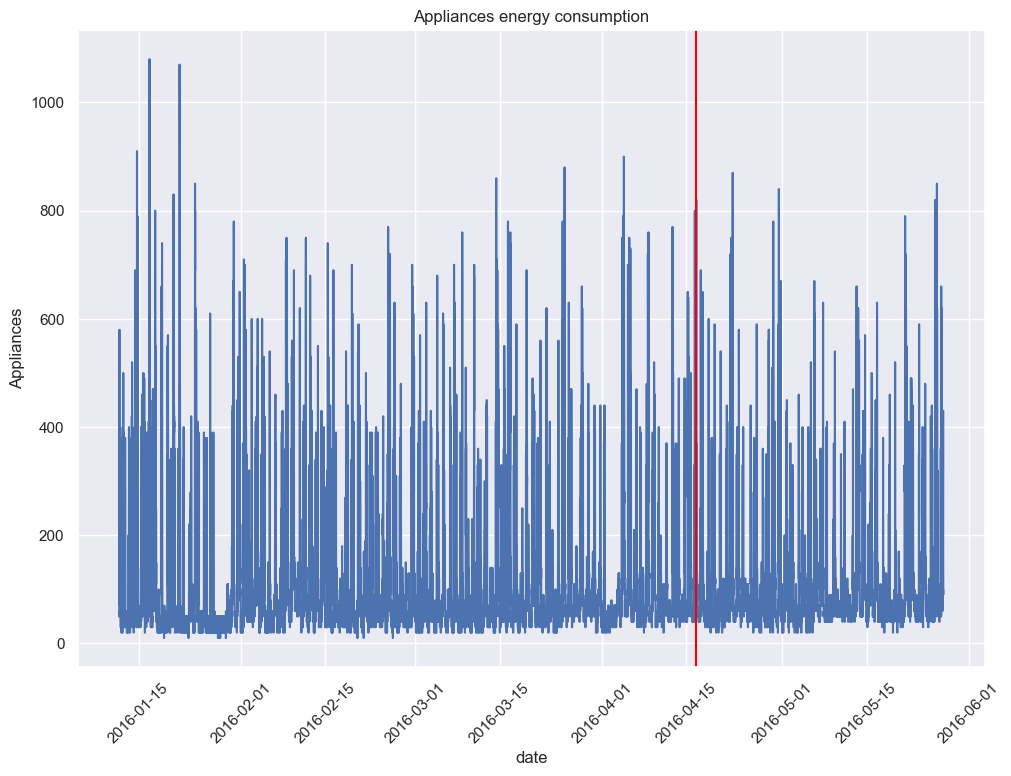

In [29]:
sns.lineplot(x=df.index, y="Appliances", data=df)
plt.xticks(rotation = 45)
plt.axvline(max(train.index), color='red')
plt.title("Appliances energy consumption")
plt.show()

The red line shows where the data is split. Everything to the left of the red line will be the train dataset and everything to the right is the test dataset (unseen data).

In [30]:
# scale X_train and X_test
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [31]:
# Doing train-test-split 
X_train, y_train = train[:, 1:], train[:,0]
X_test, y_test = test[:, 1:], test[:,0]

#### 3.2. Time-series Analysis

This code leverages both statsmodels and pmdarima for using Time-series analysis and forecasting. We'll explore by manually setting avalues of *p, d* and *q* for ARIMA, and then compare this using pmdarima's implementation or Auto-ARIMA. Exploring the dataset is done in ```3.2```, but prediction will be done in ```4```. Another note is that for this analysis, we will use the entire dataset's target to confirm find the optimal parameters for our ARIMA model, but we will only be using the train set (in sample) to make our predictions on the test (out sample).

In [32]:
# install statsmodels and pmdarima if you have not
# !python -m pip install statsmodels
# !python -m pip install pmdarima

##### 3.2.1. Seasonal Decomposition


First, we inspect the seasonality of the dataset, since this will affect [which flavor of ARIMA we will use](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)[7].

Model assumption: additive


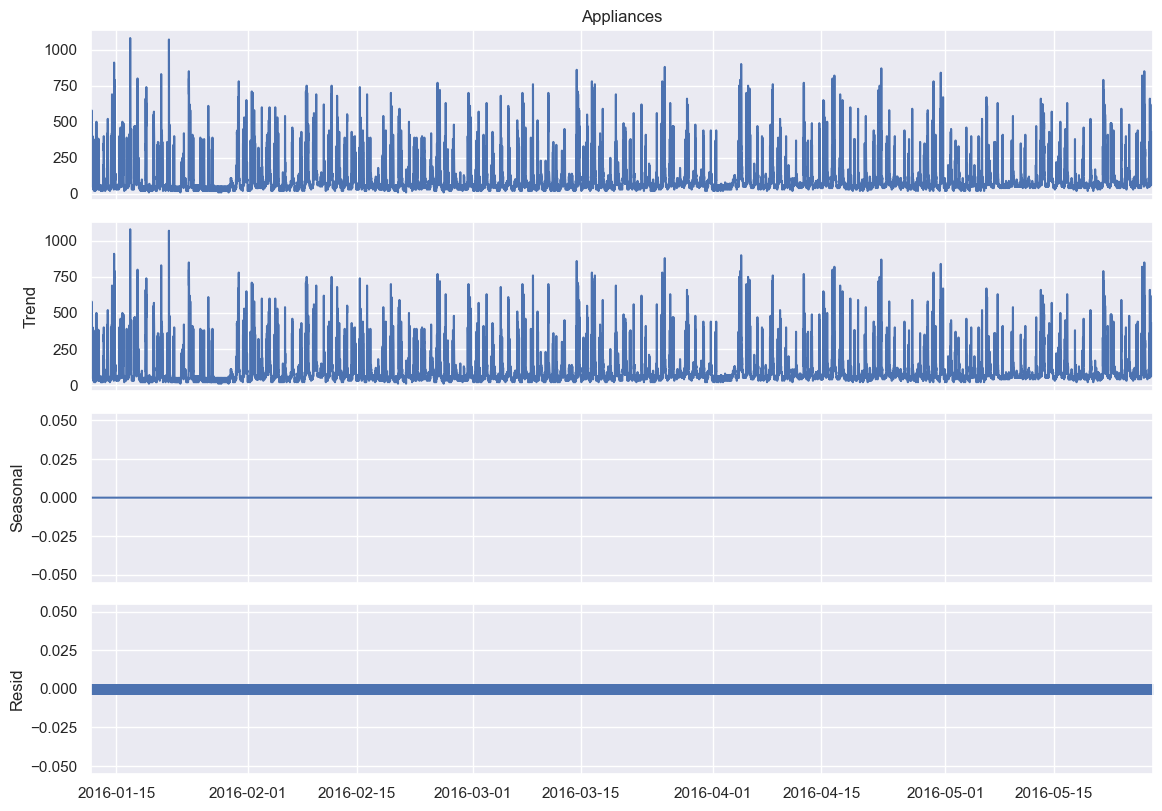

Model assumption: multiplicative


<Figure size 1170x827 with 0 Axes>

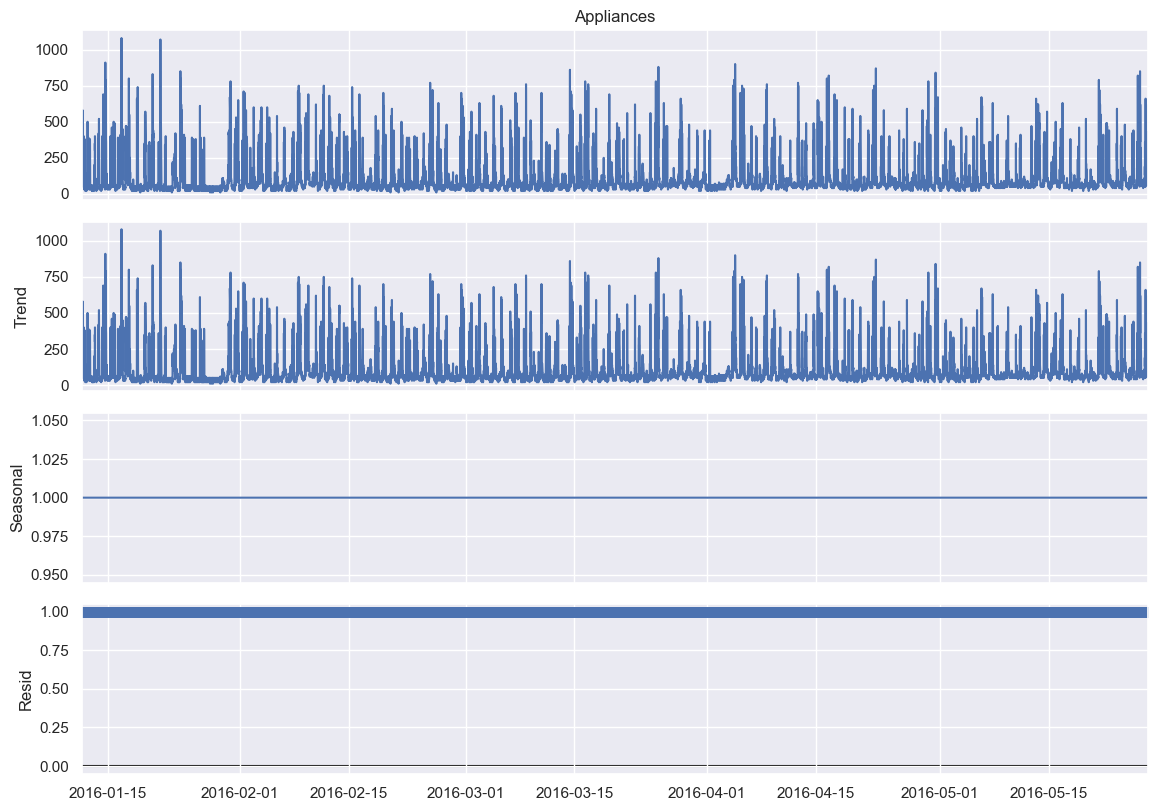

<Figure size 1170x827 with 0 Axes>

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = df["Appliances"]
models = ['additive', 'multiplicative']
for model in models:
    print(f"Model assumption: {model}")
    result = seasonal_decompose(series, model=model, period=1)
    result.plot()
    plt.show()
    plt.clf()

Given the seasonal analysis of the target variable Appliances, it can be seen in the charts above that there is data is not seasonal component using either assumption.

##### 3.2.2. Stationarity & Order Differencing (I)

To check for stationarity, we will check the [augmented Dickey-Fuller test (ADF)](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)[8] since it is an assumption that needs to be fulfilled to use ARIMA. The null hypothesis for this test is that the series is non-stationarity.

In [34]:
# Augmented Dickey-Fuller Test (ADF) of statsmodels

# Null hypothesis is non-stationary series
# p > 0.05, indicating non-stationary series (reject the null)

result_s_ADF = s_ADF(df["Appliances"])

print(f'ADF Statistics: {result_s_ADF[0]: .2f}')
print(f'p-value: {result_s_ADF[1]: .4f}')
print('Critical Values: ')
for key, value in result_s_ADF[4].items():
    print(f'\t{key: <4s}: {value: .3f}')
    


ADF Statistics: -21.62
p-value:  0.0000
Critical Values: 
	1%  : -3.431
	5%  : -2.862
	10% : -2.567


It can be seen that the p-value for the Appliances is less 0.05 (confidence level), which indicate that the data is stationary. From this we can say that the value d = 0 can be used for our ARIMA(p,d,q) model. One flavor of ARIMA is ARMA(p,q) where I = 0 since that data being predicted is already staionary. 

##### 3.2.3. Auto Regression and Moving Average

Now that we have the optimal value of d, the values of p and d can be derived using the auto-correlation (ACF) and partial auto-correlation (PACF) plot

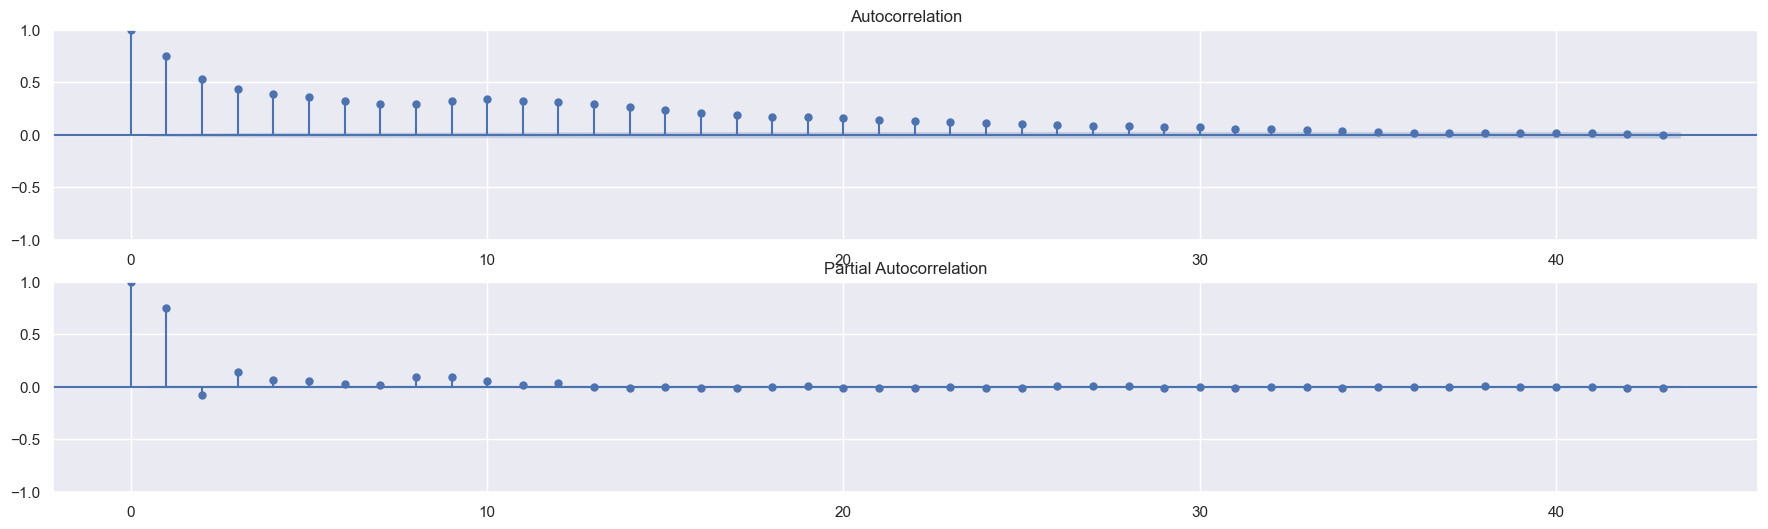

In [35]:
fig, ax = plt.subplots(2,1,figsize=(22,6), sharex=False)
sm.graphics.tsa.plot_acf(df["Appliances"], ax=ax[0])
sm.graphics.tsa.plot_pacf(df["Appliances"], ax=ax[1])
plt.show()

Looking at the graph, we can see the in the PACF plot that in p = 1 (the first lag), is significantly out of the limit, and while p = 2 is out of limit, is less so, informally we can set that p = 1. Likewise when looking at the ACF plot, it is quite unclear where the "lag out" is. We can experiment this by setting d = 1. However, we will compare the performance of these parameters using [auto-ARIMA](https://www.rdocumentation.org/packages/forecast/versions/8.14/topics/auto.arima)[9] since this finds the optimal parameters using AIC and BIC statistical tests.

### 4. Implement, train and test prediction models

#### Note: Metrics

The following [metrics](https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e)[13] will be used for this experiment:


**R-squared (R²)**

* Formula: $R^2 = 1 - \dfrac{\sum\limits_{i=1}^{n} (y_i - \hat{y_i})^2}{\sum\limits_{i=1}^{n} (y_i - \overline{y})^2}$

* Description: R-squared is a statistical metric used to evaluate the performance of regression models. It represents the proportion of variance in the dependent variable (y) that is explained by the independent variable(s) (x). A value of 1 indicates a perfect fit, while 0 indicates no linear relationship.

**Root Mean Squared Error (RMSE)**

* Formula: $RMSE = \sqrt{\dfrac{\sum\limits_{i=1}^{n} (y_i - \hat{y_i})^2}{n}}$

* Description: RMSE is a metric used to measure the magnitude of the difference between predicted values ($\hat{y_i}$ ) and actual values (y_i). It penalizes larger errors more severely compared to MAE. Lower RMSE values indicate a better fit.

**Mean Absolute Error (MAE)**

* Formula: $MAE = \dfrac{\sum\limits_{i=1}^{n} |y_i - \hat{y_i}|}{n}$

* Description: MAE is another metric used to measure the average magnitude of the errors between predicted and actual values. It takes the absolute difference between each prediction and its corresponding actual value, and then averages them. MAE is less sensitive to outliers compared to RMSE. Lower MAE values indicate a better fit.

**Key:**

* n: number of data points
* y_i: actual value for the i-th data point
* $\hat{y_i}$: predicted value for the i-th data point
* $\overline{y}$: mean of the actual values

#### 4.1. ARIMA 

##### 4.1.1. ARIMA(1,0,1)

Using ARIMA(1,0,1) after our previous calculations to make predictions.

In [36]:
ARIMA_model = ARIMA(y_train, order=(1,0,1))
ARIMA_model_fit = ARIMA_model.fit()
print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                13814
Model:                 ARIMA(1, 0, 1)   Log Likelihood               18198.103
Date:                Sun, 17 Mar 2024   AIC                         -36388.205
Time:                        22:26:52   BIC                         -36358.072
Sample:                             0   HQIC                        -36378.167
                              - 13814                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0830      0.004     20.936      0.000       0.075       0.091
ar.L1          0.7030      0.006    125.348      0.000       0.692       0.714
ma.L1          0.1306      0.006     22.225      0.0

The following can be interpreted from the summary.
Note: this was adapted from [this site](https://analyzingalpha.com/interpret-arima-results)[10]
Breaking it down the following can be observed:
- The coefficients terms are all significant given that their p-values are less than 0.05
- The p-value of the Ljung-Box chi-squere is > 0.05, and this means that the residuals are independent (which is what we want).
- The p-value for the Jarque-Bera statistic is < 0.05, and this means that the data is not normally distributed.
- The p-value for Heteroskedasticity is < 0.05, which means that heteroskedasticity is present in the residuals which causes errors for our ARIMA model.

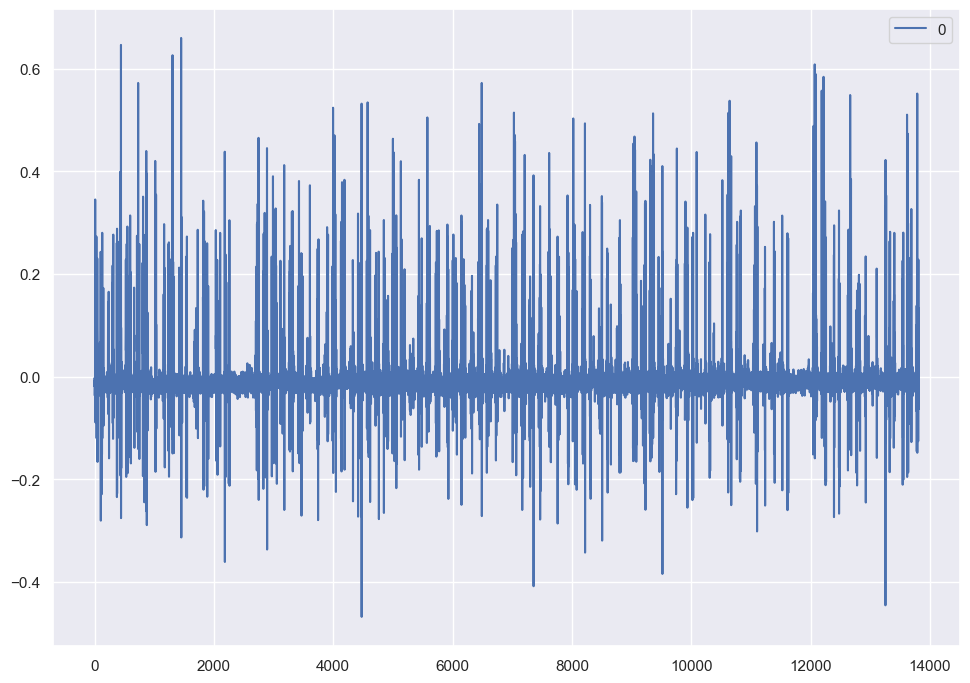

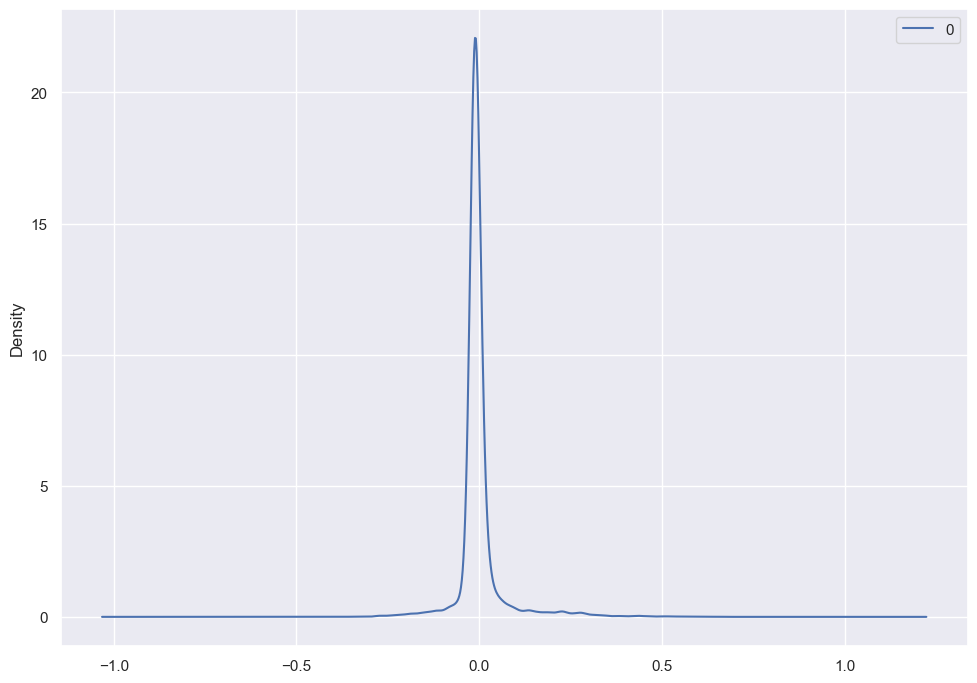

                  0
count  13814.000000
mean       0.000003
std        0.064810
min       -0.468134
25%       -0.018624
50%       -0.009515
75%        0.001743
max        0.659778


In [37]:
# line plot of residuals
residuals = pd.DataFrame(ARIMA_model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Model prediction and visualization

In [38]:

# predict perfomance on train
train_predictions = ARIMA_model_fit.predict(start=0, end=len(y_train)-1)

# evaluate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)
print("Train Results of ARIMA(1,0,1):")
print("Root Mean Squared Error (RMSE) on y_train:", train_rmse)
print("Root Mean Squared Error (MAE) on y_train:", train_mae)
print("R2 score on y_train:", train_r2)
print('-' * 16)

# predict performance on test
y_pred = ARIMA_model_fit.forecast(steps=len(y_test))

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print("Test Results of ARIMA(1,0,1):")
print("Root Mean Squared Error (RMSE) on y_test:", test_rmse)
print("Root Mean Squared Error (MAE) on y_test:", test_mae)
print("R2 score on y_test:", test_r2)

Train Results of ARIMA(1,0,1):
Root Mean Squared Error (RMSE) on y_train: 0.0648077372332452
Root Mean Squared Error (MAE) on y_train: 0.029928686090216088
R2 score on y_train: 0.5788426494742751
----------------
Test Results of ARIMA(1,0,1):
Root Mean Squared Error (RMSE) on y_test: 0.08564913389452028
Root Mean Squared Error (MAE) on y_test: 0.04989833206572404
R2 score on y_test: -0.0015109258901342404


While the results of the tests are promising, we cannot forget that the ARIMA(1,0,1) model does not particularly hold as it fails some assumptions as reported in the summary above. We can compare this with Auto-ARIMA to get the best performing parameters and add this to our comparison

Text(0.5, 1.0, 'Actual vs Predicted Values')

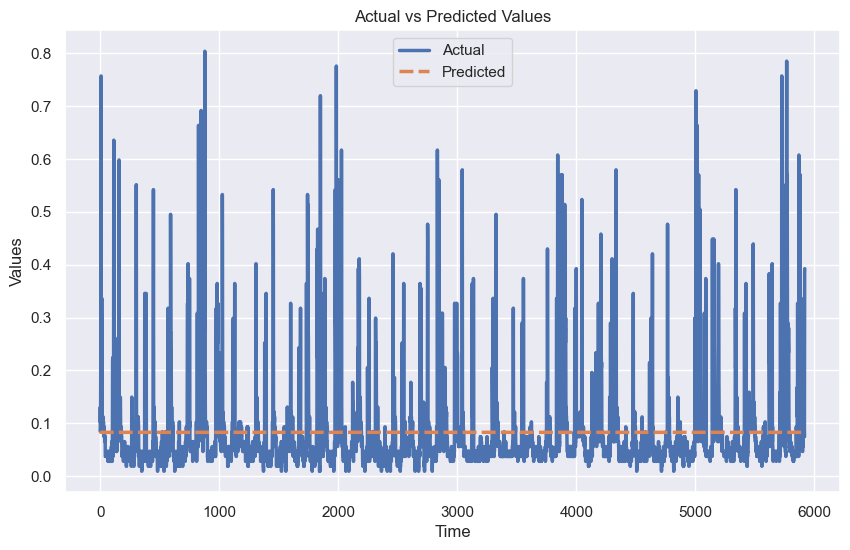

In [39]:
# Plotting Actual vs Predicted
data = {'Actual': y_test, 'Predicted': y_pred}
df = pd.DataFrame(data)

# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, linewidth=2.5)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')

Text(0.5, 1.0, 'Actual - Predicted Values')

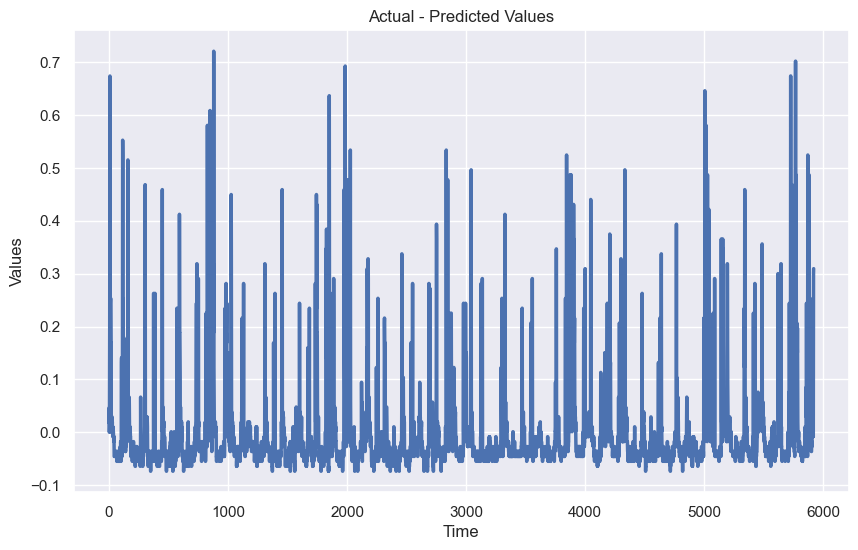

In [40]:
# Plotting Actual vs Predicted (Difference)
# Values closer to 0 is better
df = pd.DataFrame(data)

# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=(y_test-y_pred), linewidth=2.5)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual - Predicted Values')

#### 4.1.2. Auto-ARIMA

"The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. This process is based on the commonly-used R function, forecast::auto.arima [3].

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D."[11]

In [41]:
# Fit Auto ARIMA model
# Remember that the data does not hint any seasonality.
auto_arima_model = auto_arima(y_train,seasonal=False,trace=True) 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-36687.509, Time=3.94 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-17198.622, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-35538.564, Time=0.46 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-27623.661, Time=1.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-36237.259, Time=5.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-35615.623, Time=2.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-36687.508, Time=5.86 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-36687.667, Time=9.92 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-36608.864, Time=10.46 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-36649.934, Time=12.72 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-36610.862, Time=14.29 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-36675.050, Time=8.92 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-36370.312, Time=14.75 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-36725.415, Time=24.25 sec


In [42]:
# analyze the model
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                13814
Model:               SARIMAX(2, 0, 5)   Log Likelihood               18429.126
Date:                Sun, 17 Mar 2024   AIC                         -36840.253
Time:                        22:34:40   BIC                         -36772.452
Sample:                             0   HQIC                        -36817.666
                              - 13814                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0044      0.001      3.496      0.000       0.002       0.007
ar.L1          0.7951      0.266      2.992      0.003       0.274       1.316
ar.L2          0.1516      0.252      0.601      0.548      -0.343       0.646
ma.L1          0.0039      0.266      0.015      0.988      -0.517       0.525
ma.L2         -0.3275      0.041     -8.083      0.000      -0.407      -0.248
ma.L3         -0.1854      0.081     -2.298      0.022      -0.343      -0.027
ma.L4         -0.0732      0.038     -1.912      0.056      -0.148       0.002
ma.L5         -0.0319      0.014     -2.202      0.028      -0.060      -0.004
sigma2         0.0041    2.1e-05    193.899      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):            288668.68
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             3.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Similar to the above the following observations can be made:
- The coefficients terms are all significant given that their p-values are less than 0.05
- The p-value of the Ljung-Box chi-squere is > 0.05, and this means that the residuals are independent (which is what we want).
- The p-value for the Jarque-Bera statistic is < 0.05, and this means that the data is not normally distributed.
- The p-value for Heteroskedasticity is < 0.05, which means that heteroskedasticity is present in the residuals which causes errors for our ARIMA model.

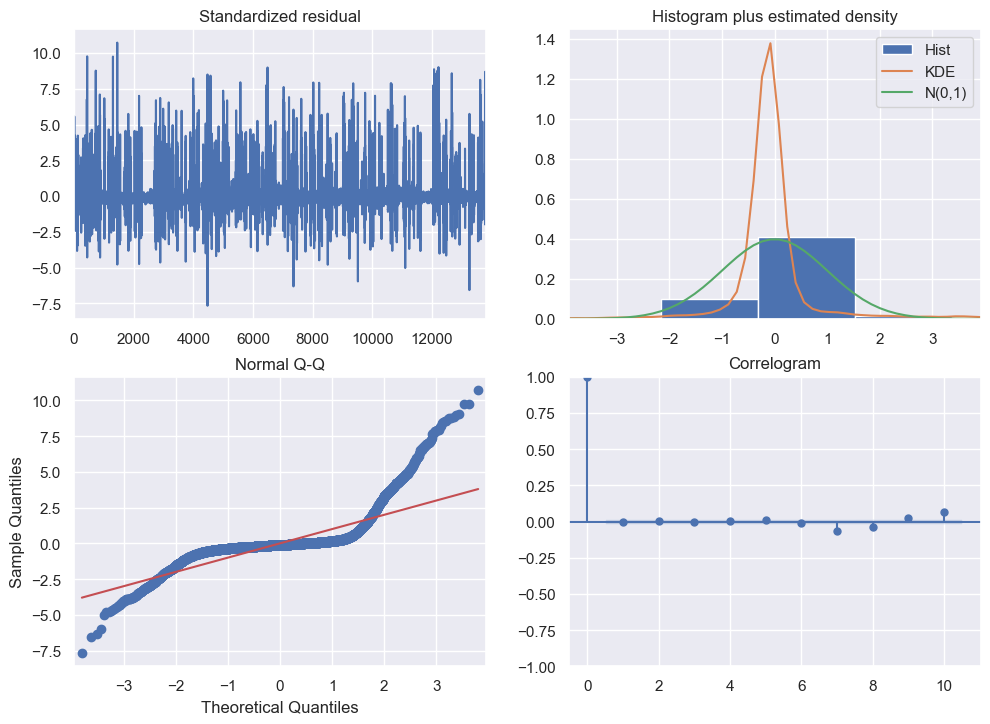

In [43]:
# we can view the relevant plots using plot_diagnostics
auto_arima_model.plot_diagnostics()
plt.show()

As explained a while ago, the graph of residuals show heteroskedasticity. The Normal Q-Q plot indicate that the residuals do not folow a normal distribution.

Model prediction and visualization

In [44]:
# predict perfomance on train
train_predictions = auto_arima_model.predict_in_sample(start=0, end=len(y_train)-1)

# evaluate s
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)
print("Train Results of Auto-Arima:")
print("Root Mean Squared Error (RMSE) on y_train:", train_rmse)
print("Root Mean Squared Error (MAE) on y_train:", train_mae)
print("R2 score on y_train:", train_r2)
print('-' * 16)

# predict performance on test
y_pred = auto_arima_model.predict(y_test.shape[0])

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print("Test Results of Auto-Arima:")
print("Root Mean Squared Error (RMSE) on y_test:", test_rmse)
print("Root Mean Squared Error (MAE) on y_test:", test_mae)
print("R2 score on y_test:", test_r2)

Train Results of Auto-Arima:
Root Mean Squared Error (RMSE) on y_train: 0.06373260316136081
Root Mean Squared Error (MAE) on y_train: 0.029202340270942196
R2 score on y_train: 0.5927004000165264
----------------
Test Results of Auto-Arima:
Root Mean Squared Error (RMSE) on y_test: 0.08544547324610832
Root Mean Squared Error (MAE) on y_test: 0.04964168506255524
R2 score on y_test: 0.0032462935323928077


An extensive comparison will be made later, but at a quick glance ARIMA(2,0,5) performs significantly worse than ARIMA(1,0,1).

Text(0.5, 1.0, 'Actual vs Predicted Values')

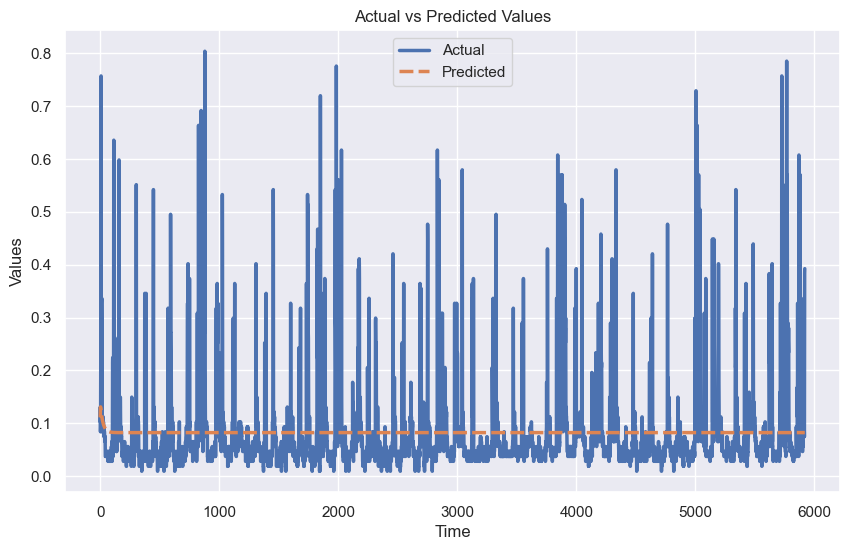

In [45]:
# Plotting Actual vs Predicted
data = {'Actual': y_test, 'Predicted': y_pred}
df = pd.DataFrame(data)

# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, linewidth=2.5)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')

Text(0.5, 1.0, 'Actual - Predicted Values')

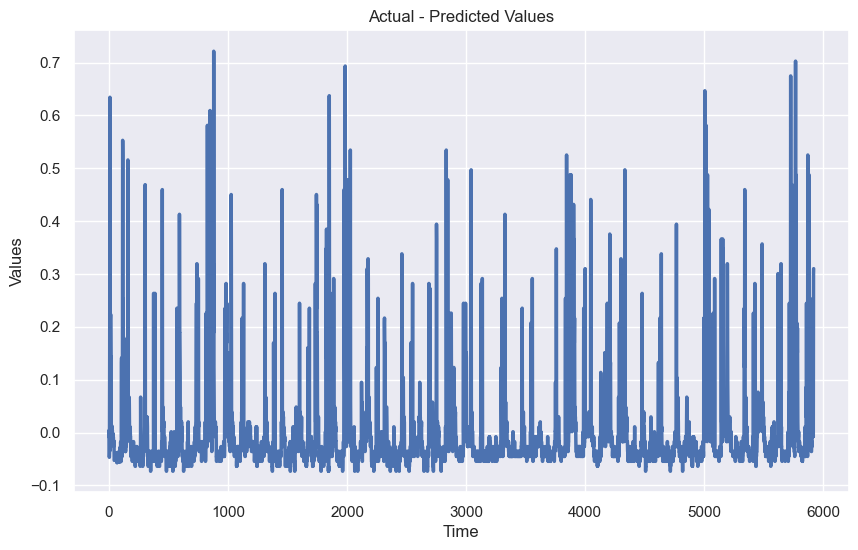

In [46]:
# Plotting Actual vs Predicted (Difference)
# Values closer to 0 is better
df = pd.DataFrame(data)

# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=(y_test-y_pred), linewidth=2.5)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual - Predicted Values')

#### 4.2. LSTM

"Long short-term memory (LSTM)[1] network is a recurrent neural network (RNN), aimed at dealing with the vanishing gradient problem[2] present in traditional RNNs. Its relative insensitivity to gap length is its advantage over other RNNs, hidden Markov models and other sequence learning methods. It aims to provide a short-term memory for RNN that can last thousands of timesteps, thus "long short-term memory."[12]

Note: I am adapting the code given after workshop 2 to make the LSTM prediction models. This approach is useful since it allows more data on a per row level dictate the predicted value since it is now aggregated to a per hour level. (To be pendantic about it, the data is transformed to be x[t], x[t-1], ..., x[t-n] per row - not exactly the same as aggregation)

In [47]:
# This code is adapted from the workshop
# Same as univariate_data above.
# data is: samples taken every 10 min. -> Still applies to our data set

# New params:
# step: instead of taking data for each 10min, you want to generate data once evrey 6 steps (60min)
#### so one sample per hour -> Might be fruitful to apply 
# single_step: lables from single timestamp or multiple timesteps

## it takes not just one y, but all x and historical T, therefore multivariate
#### y to predict is next y after train+step

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

##### 4.2.1. Multivariate and single-step forecasting

In [48]:
# 90% of train will be used with 10% of train will be used for validation
TRAIN_SPLIT = int(0.9 * X_train.shape[0])

# This code is to split the data into holdout and train sets - after some lag adjustments
# past_history = 720 # 720*10 mins -> 5 days * 24 hrs * 6 readings per hours
# future_target = 72 # 72*10 mins -> 12 hrs after 
STEP = 6 # one obs every 6X10min = 60 min => 1 hr

# for this experiment lets consider history to be the last 7 days (week)
# while future target stays at 12 hours after.

past_history = 7 * 24 * 6
future_target = 72 # 72*10 mins -> 12 hrs after 

X_train_single, y_train_single = multivariate_data(train, y_train, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
X_val_single, y_val_single = multivariate_data(train, y_train,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(X_train_single.shape)
print(y_train_single.shape)
print(X_val_single.shape)
print(y_val_single.shape)

(11424, 168, 36)
(11424,)
(302, 168, 36)
(302,)


In [49]:
# Make tf_datasets from the slices above

BATCH_SIZE = 256 # batch size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_data_single = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((X_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 168, 36), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 168, 36), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [50]:
EPOCHS = 20
STEPS_PER_EPOCH = 100

In [51]:
# Vanilla LST with one neuron 
# We optimise on RMSE to keep our experimentation fair
def rmse(y_true, y_pred):
    out = tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 
    out = tf.cast(out, tf.float64)
    return out

def r_squared(y_true, y_pred):
  """Calculates R-squared metric between true and predicted values.

  Args:
    y_true: TensorFlow tensor of true target values. dtype must be float64.
    y_pred: TensorFlow tensor of predicted target values. dtype must be float64.

  Returns:
    A TensorFlow tensor with the R-squared value. dtype is float64.
  """

  y_true = tf.cast(y_true, tf.float64)
  y_pred = tf.cast(y_pred, tf.float64)

  mean_y_true = tf.reduce_mean(y_true)
  # total error
  ss_tot = tf.reduce_sum(tf.square(y_true - mean_y_true))
  # unexplained error
  ss_res = tf.reduce_sum(tf.square(y_true - y_pred))

  r2 = tf.cast(1 - ss_res / (ss_tot + tf.keras.backend.epsilon()), tf.float64)
  return r2

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=X_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

# We used adam due to its robustness in deep neural network training optimization
single_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=rmse, metrics=["mae",r_squared])

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/20


/Users/nic/anaconda3/envs/CS7306/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 270ms/step - loss: 0.1859 - mae: 0.1482 - r_squared: -1345.9810 - val_loss: 0.1290 - val_mae: 0.0723 - val_r_squared: -162.7171
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 276ms/step - loss: 0.0925 - mae: 0.0555 - r_squared: -287.1780 - val_loss: 0.1401 - val_mae: 0.0751 - val_r_squared: -205.4446
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 312ms/step - loss: 0.0880 - mae: 0.0509 - r_squared: -303.2931 - val_loss: 0.1282 - val_mae: 0.0701 - val_r_squared: -184.5020
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - loss: 0.0863 - mae: 0.0503 - r_squared: -304.3640 - val_loss: 0.1269 - val_mae: 0.0714 - val_r_squared: -187.8137
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - loss: 0.0861 - mae: 0.0503 - r_squared: -306.7747 - val_loss: 0.1366 - val_mae: 0.0792 - val_r_squared: -213.9055
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 228ms/step - loss: 0.0854 - mae: 0.0501 - r_squared: -319.5098 - val_loss: 0.1301 - val_mae: 0.0771 - val_r_squ

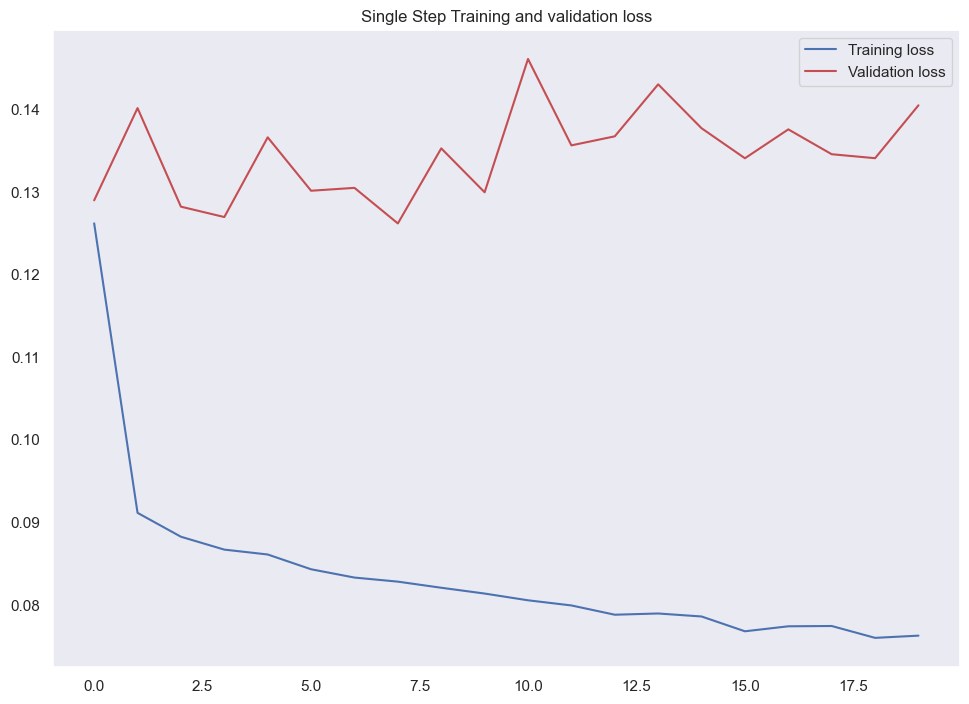

In [52]:
# Plot train and validation loss over epochs
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [54]:
best_loss_ind = -1
best_loss = float('inf')
for i in range(len(single_step_history.history['loss'])):
    if single_step_history.history['loss'][i] < best_loss:
        best_loss_ind = i
        best_loss = single_step_history.history['loss'][i]


for k in [x for x in single_step_history.history.keys()]:
    print(f"{k} score ")
    print(single_step_history.history[k][best_loss_ind])

loss score 
0.07598637044429779
mae score 
0.043769437819719315
r_squared score 
-354.6706237792969
val_loss score 
0.1340511292219162
val_mae score 
0.07700604945421219
val_r_squared score 
-204.9416961669922


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


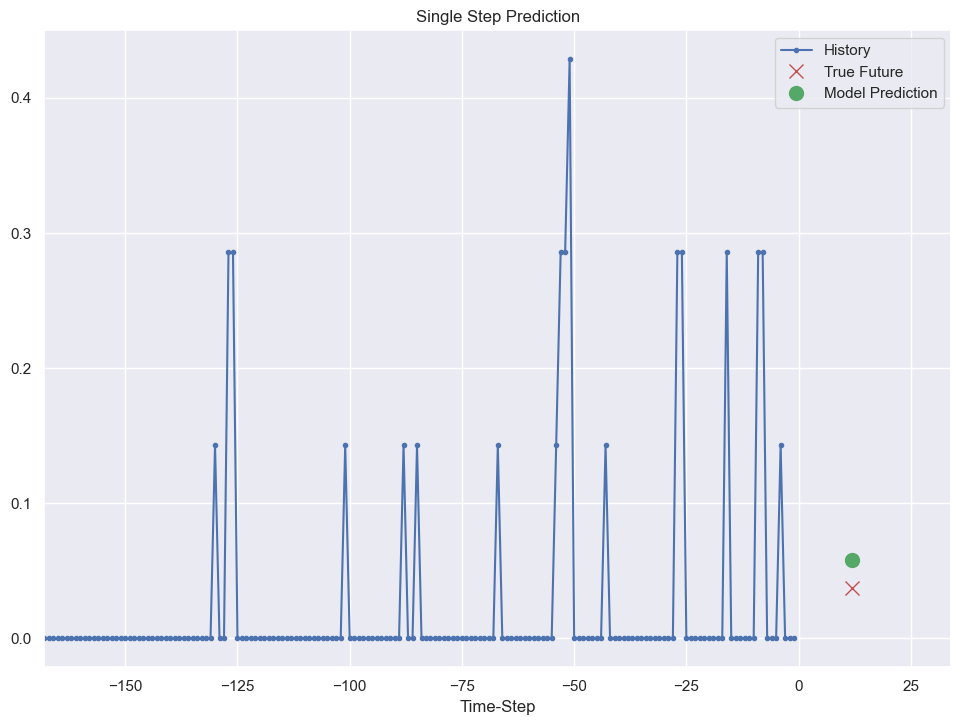

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


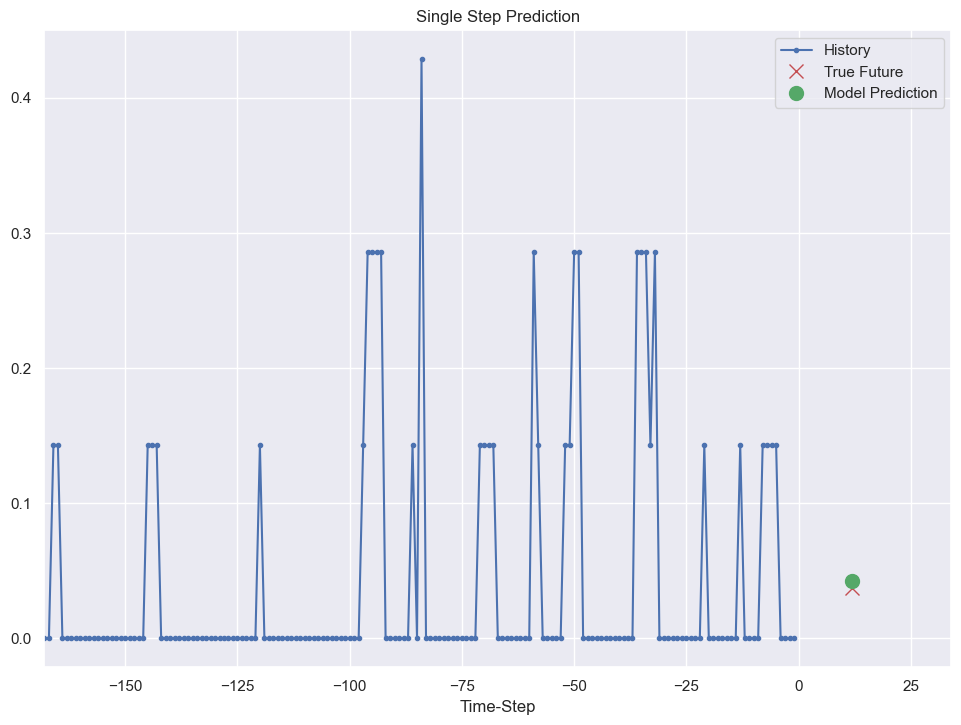

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


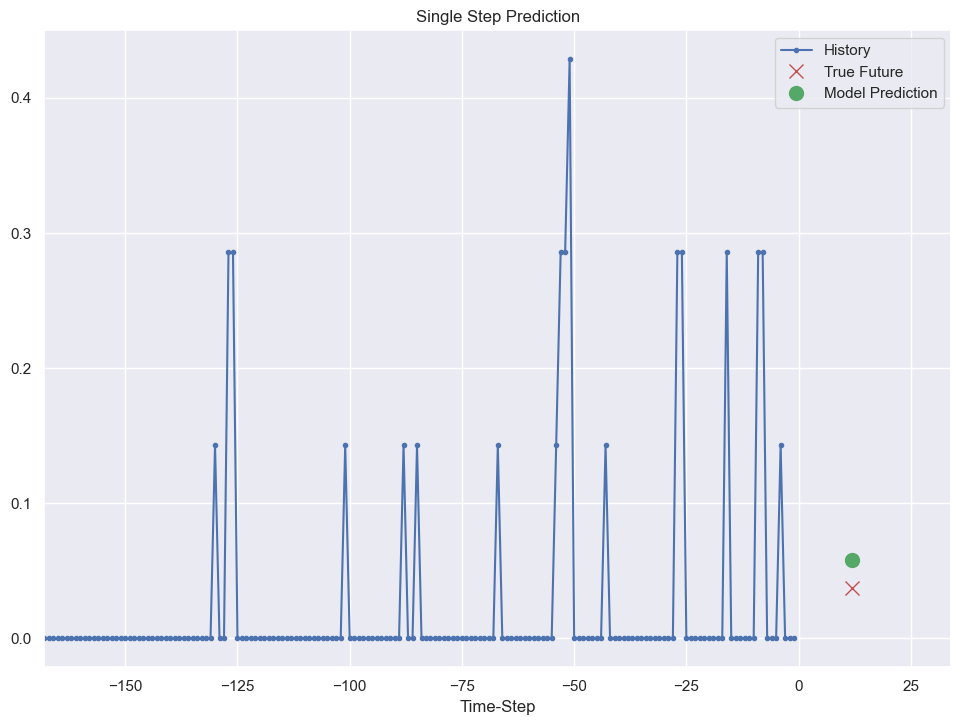

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


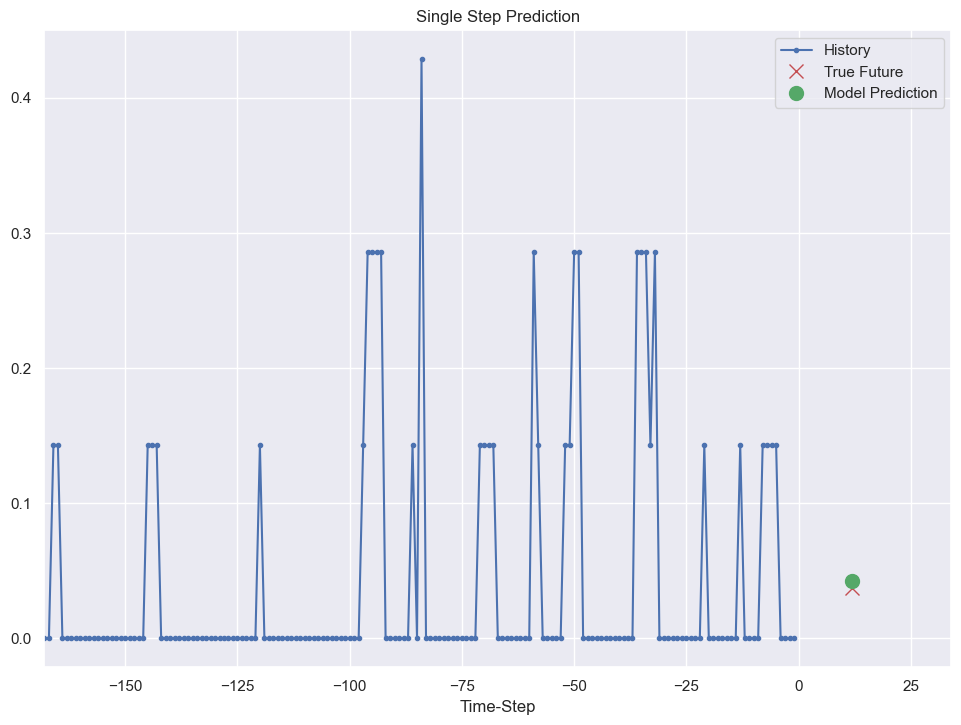

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


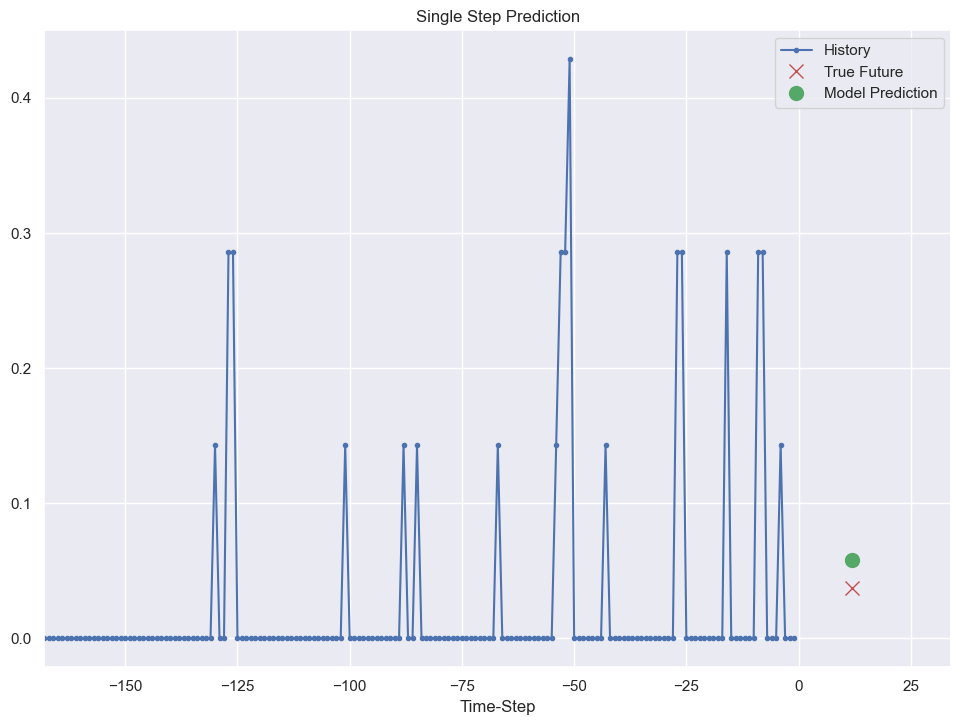

2024-03-17 22:43:18.869740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [55]:
def create_time_steps(length):
  return list(range(-length,0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

The LSTM performed much poorer that the ARIMA model; additionally, the loss curves indicate possibility of overfitting since it fails to capture the unseen data. Instead of single-step predictions, now we will try to predict multi-step.

##### Multi-variate and multiple-step forecasting

In [56]:
# single_step=FALSE default value

future_target = 72 # 72 future values
x_train_multi, y_train_multi = multivariate_data(train, y_train, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(train, y_train,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(11424, 168, 36)
(11424, 72)
(302, 168, 36)
(302, 72)


In [57]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [58]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
# Introduced Hidden Activation Layer
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=rmse, metrics=["mae",r_squared])

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/20


/Users/nic/anaconda3/envs/CS7306/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 406ms/step - loss: 0.1185 - mae: 0.0707 - r_squared: -0.5131 - val_loss: 0.1036 - val_mae: 0.0558 - val_r_squared: -0.0345
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 444ms/step - loss: 0.0948 - mae: 0.0560 - r_squared: 0.0524 - val_loss: 0.1031 - val_mae: 0.0584 - val_r_squared: -0.0261
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 577ms/step - loss: 0.0915 - mae: 0.0530 - r_squared: 0.1203 - val_loss: 0.1034 - val_mae: 0.0592 - val_r_squared: -0.0296
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 586ms/step - loss: 0.0870 - mae: 0.0488 - r_squared: 0.2041 - val_loss: 0.1012 - val_mae: 0.0655 - val_r_squared: 0.0137
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 624ms/step - loss: 0.0833 - mae: 0.0464 - r_squared: 0.2653 - val_loss: 0.1006 - val_mae: 0.0715 - val_r_squared: 0.0232
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 58s 577ms/step - loss: 0.0814 - mae: 0.0452 - r_squared: 0.3011 - val_loss: 0.0984 - val_mae: 0.0644 - val_r_squared: 0.0654
Epoch 7/20
100/10

In [59]:
best_loss = float('inf')
best_loss_ind = -1
for i in range(len(multi_step_history.history['loss'])):
    if multi_step_history.history['loss'][i] < best_loss:
        best_loss_ind = i
        best_loss = multi_step_history.history['loss'][i]

# best scores for multivariate vanilla RNN single step
for k in [x for x in multi_step_history.history.keys()]:
    print(f"{k} score ")
    print(multi_step_history.history[k][best_loss_ind])

loss score 
0.07441911846399307
mae score 
0.04023639112710953
r_squared score 
0.41901150345802307
val_loss score 
0.110494464635849
val_mae score 
0.07239166647195816
val_r_squared score 
-0.17536590993404388


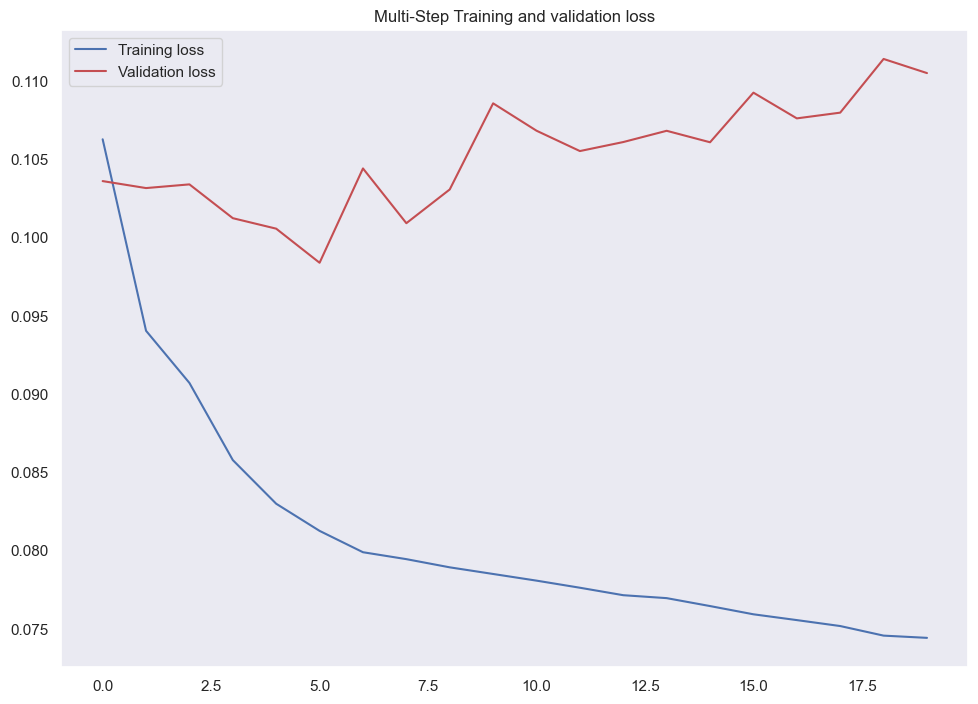

In [60]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step


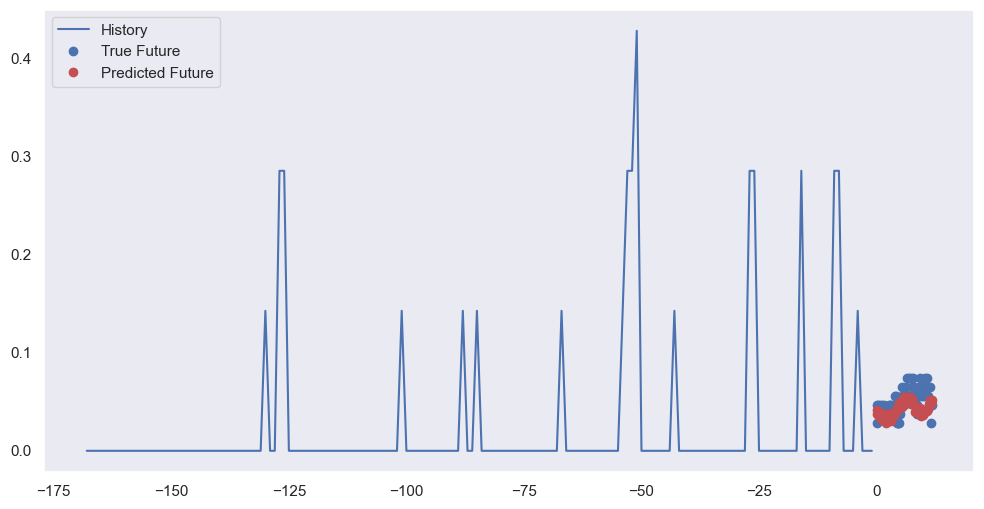

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  


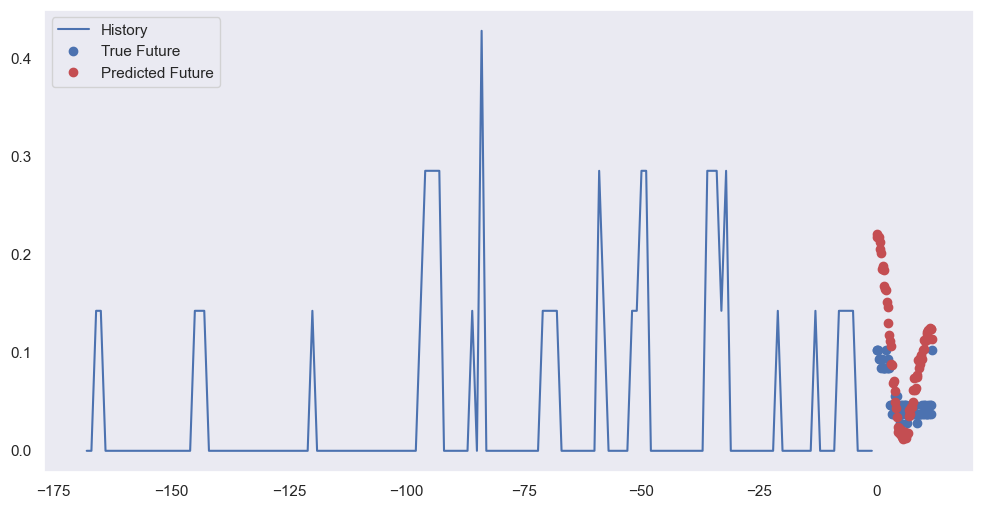

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


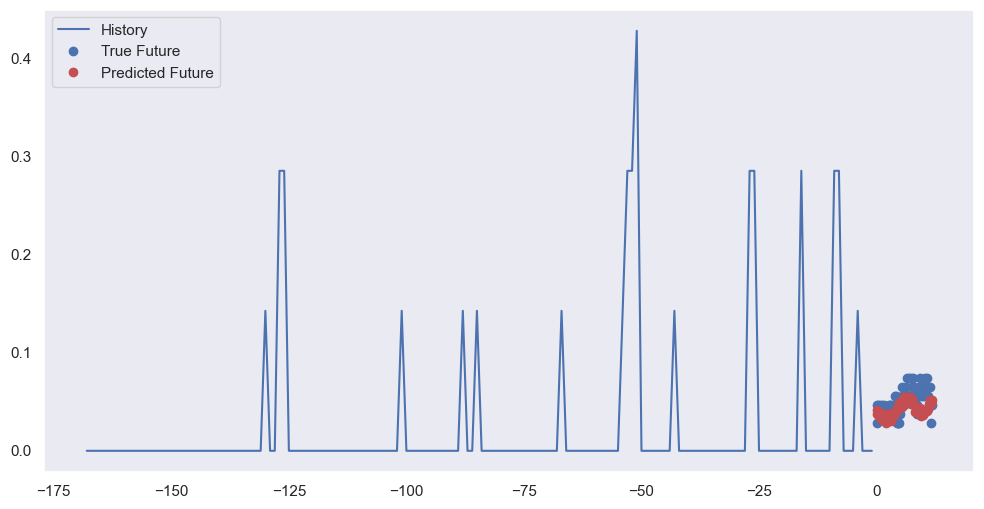

2024-03-17 23:16:51.259159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [61]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  

for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

On an eyeball test, it can be seen that the model predicted validation pretty well. However, looking at the loss curve we can see that the training loss is significantly lower than the validation loss which might indicate possible overfitting. Now to evaluate this on test.

In [62]:
y_pred = multi_step_model.predict(x_train_multi[-len(y_test)// 72:])
y_pred

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


array([[0.06599829, 0.06232031, 0.07059965, ..., 0.04616865, 0.04741793,
        0.04121564],
       [0.06636937, 0.06254189, 0.07121593, ..., 0.04766864, 0.04894364,
        0.04311588],
       [0.06624497, 0.0631391 , 0.07043717, ..., 0.04177471, 0.0429561 ,
        0.03603838],
       ...,
       [0.04194316, 0.03871786, 0.03941049, ..., 0.05064066, 0.05127111,
        0.05407949],
       [0.04165027, 0.03831011, 0.03926046, ..., 0.0507811 , 0.05141201,
        0.05437716],
       [0.04179475, 0.03859569, 0.03925864, ..., 0.05073309, 0.05138589,
        0.05412688]], dtype=float32)

In [63]:
y_pred = y_pred.reshape(1,-1)[0][:len(y_test)]
y_pred

array([0.06599829, 0.06232031, 0.07059965, ..., 0.03430877, 0.03398257,
       0.03449517], dtype=float32)

RMSE on test:
0.09310735264887558
R2 on test:
-0.1835257111613151
MAE on test:
0.05077609011615557


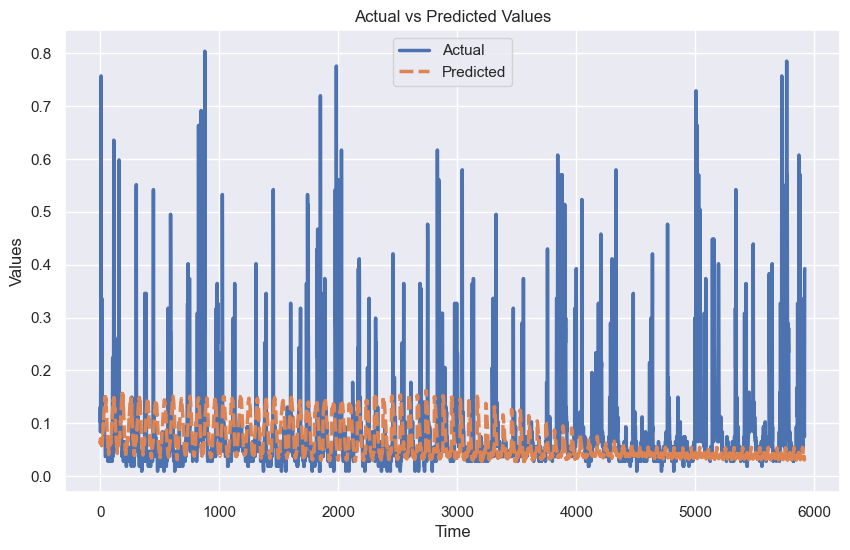

In [64]:
# Create a DataFrame for visualization
print("RMSE on test:")
print(mean_squared_error(y_test, y_pred) ** 0.5)
print("R2 on test:")
print(r2_score(y_test, y_pred))
print("MAE on test:")
print(mean_absolute_error(y_test, y_pred))

# Visualize the predicted results vs actual
# Create a DataFrame for visualization
data = {'Actual': y_test, 'Predicted': y_pred}
df = pd.DataFrame(data)

# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, linewidth=2.5)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Actual - Predicted Values')

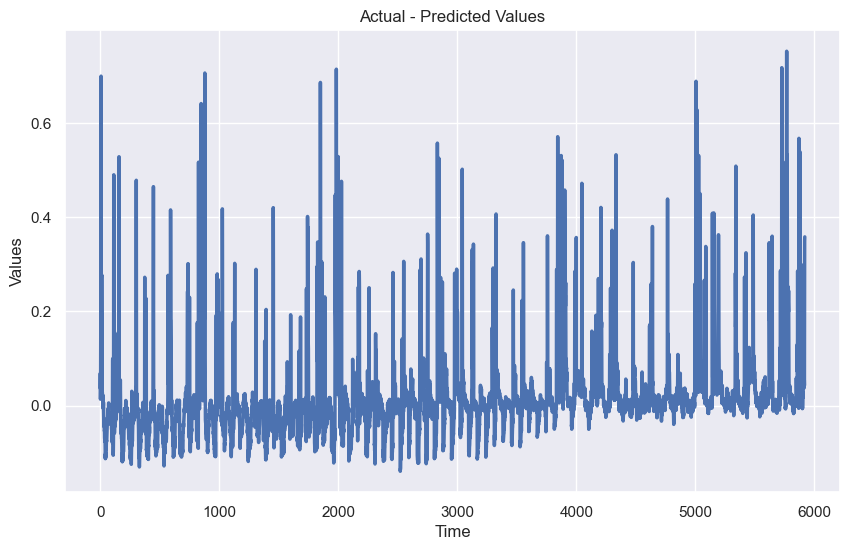

In [65]:
# Plotting Actual vs Predicted (Difference)
# Values closer to 0 is better
df = pd.DataFrame(data)

# Plot the line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=(y_test-y_pred), linewidth=2.5)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Actual - Predicted Values')

### 5. Compare the results from all candidate models, choose the best model, justify your choice and discuss the results


Compare with the results you have obtained in Assignment 1a.

Rerunning my Assignment 1a with new metrics and normalization, the table below summarizes the performance of the experiments.
| Model                      | RMSE (Train)        | MAE (Train)        | R2 (Train)          | RMSE (Test) | MAE (Test)  | R2 (Test)    |
|----------------------------|-------------|-------------|-------------|-------------|-------------|--------------|
| Random Forest              | 0.09458732  | 0.064259076 | -0.02967978 | 0.109982637 | 0.083060152 | -0.651421739 |
| Gradient Boosted Trees     | 0.092615871 | 0.060925564 | 0.139142261 | 0.170202799 | 0.126450838 | -2.954969483 |
| XGBoost                    | 0.106173995 | 0.072879902 | -0.297396337| 0.169045839 | 0.136839813 | -2.901384092 |
| ARIMA(1,0,1)               | 0.064807737 | 0.029928686 | 0.578842649 | 0.085649134 | 0.049898332 | -0.001510926 |
| Auto-ARIMA (ARIMA(2,0,5)) | **0.063732603** | **0.02920234**  | **0.5927004**   | **0.085445473** | **0.049641685** | **0.003246294**  |
| LSTM                       | 0.074419118463993 | 0.040236391 | 0.419011503 | 0.093107353 | 0.05077609 | -0.183525711|


It can be observed that all the models from Assignment 1b has significantly outperformed the models in 1a. This shows the power of ARIMA as an out-of-the box model that rquires little training and hyperparameter turning. Additionally, the model found by Auto-Arima has also out-performed the ARIMA manually tuned. However, for LSTM, some feature selection could've benefitted it as the experiments used all the featuers for the multivariate analysis. But, it was also apparent that a somewhat relatively simple LSTM architecture has alsready out-performed the ensemble machine learning methods which also demonstrate the power of Neural Networks. Despite the ARIMA models outperforming the other methods, the assumption of heteroskedasticy has been violated so some further experimentation should be explored. To conlude, ARIMA(2,0,5) has outperformed all the models for all metrics for both in and out sample specimens.

### 6. Reflect on what you have learned by completing this assignment and how to improve the models

I learned alot regarding Time-series Analysis and Time-series forecasting for this assigment. Moreover, I also learned more aobut RLSTMS and the methods of using it to predict future values. I ran into trouble with hyperparameter tuning because Neural Networks take a lot of time to train given the horsepower of my machine.

This assignment has taught me also regarding time-series forecasting as a form of sequential data to be used for RNNs (such as the LSTM). I wish I had more time as I was planning to explore the encoding and decoding techniques that is typically used for the attention mechanism in deep learning models. Definitely a lot of improvement could be made regarding the methodlogy of this paper.

### 7. References

1. Candanedo, LM, Feldheim, V & Deramaix, D 2017, 'Data driven prediction models of energy use of appliances in a low-energy house', Energy and buildings, vol. 140, pp. 81-97.
2. https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
3. https://pandas.pydata.org/docs/user_guide/timeseries.html
4. https://www.sciencedirect.com/science/article/pii/S2666546820300094
5. https://seaborn.pydata.org/generated/seaborn.kdeplot.html
6. https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
7. https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
8. https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
9. https://www.rdocumentation.org/packages/forecast/versions/8.14/topics/auto.arima
10. https://analyzingalpha.com/interpret-arima-results
11. https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
12. https://en.wikipedia.org/wiki/Long_short-term_memory#:~:text=Long%20short%2Dterm%20memory%20\(LSTM,and%20other%20sequence%20learning%20methods
13. https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e